In [17]:
import os
import stata_setup
## 设置pystata目录
stata_setup.config(os.getenv("STATA_SYSDIR"), 'mp')

In [18]:
%stata set linesize 150

In [19]:
from pystata import stata

## 精确断点
stata.run('use "rdrobust_senate.dta", clear')


RD Plot with evenly spaced mimicking variance number of bins using spacings estimators.

         Cutoff c = 0 | Left of c  Right of c        Number of obs  =       1297
----------------------+----------------------        Kernel         =    Uniform
        Number of obs |       595         702
   Eff. Number of obs |       595         702
  Order poly. fit (p) |         4           4
     BW poly. fit (h) |   100.000     100.000
 Number of bins scale |     1.000       1.000

Outcome: vote. Running variable: margin.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |        15          35
   Average bin length |     6.667       2.857
    Median bin length |     6.667       2.857
----------------------+----------------------
    IMSE-optimal bins |         8           9
  Mimicking Var. bins |        15          35
----------------------+----------------------
Rel. to IMSE-opt

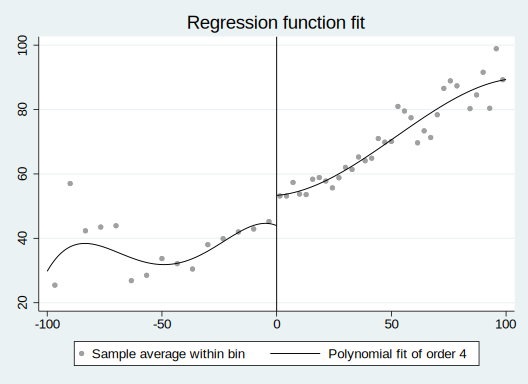

In [20]:
## 对 vote 在 margin=0 处是否存在跳跃进行图形分析
stata.run('rdplot vote margin')

In [21]:
## 计算最优带宽（输出10种计算带宽的方式，前5种的优化目标是最优带宽计算方法，后5种则是最小化覆盖误差率）
stata.run('set linesize 150')
stata.run('rdbwselect vote margin, all')


Bandwidth estimators for sharp RD local polynomial regression.

       Cutoff c =  | Left of c  Right of c            Number of obs =       1297
-------------------+----------------------            Kernel        = Triangular
     Number of obs |       595         702            VCE method    =         NN
     Min of margin |  -100.000       0.036
     Max of margin |    -0.079     100.000
    Order est. (p) |         1           1
    Order bias (q) |         2           2

Outcome: vote. Running variable: margin.
--------------------------------------------------------------------------------
                   |         BW est. (h)          |        BW bias (b)
            Method | Left of c         Right of c | Left of c        Right of c
-------------------+------------------------------+-----------------------------
             mserd |    17.754             17.754 |    28.028            28.028
            msetwo |    16.170             18.126 |    27.104            29.344
     

In [22]:
## 参数估计和统计推断  p值<< 0.001, 可以认为执政本身对下一次选举的得票率有非常显著的积极影响
stata.run('rdrobust vote margin')


Sharp RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       1297
-------------------+----------------------            BW type       =      mserd
     Number of obs |       595         702            Kernel        = Triangular
Eff. Number of obs |       360         323            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    17.754      17.754
       BW bias (b) |    28.028      28.028
         rho (h/b) |     0.633       0.633

Outcome: vote. Running variable: margin.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional |  7.4141     1.4587   5.0826   0.000     4.5551      10.2732
            Robust |     -          -  

In [24]:
## 稳健性检验
stata.run('rdrobust vote margin, bwselect(cerrd)')  # 三角核
stata.run('rdrobust vote margin, kernel(uniform)')  # 矩形核


Sharp RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       1297
-------------------+----------------------            BW type       =      cerrd
     Number of obs |       595         702            Kernel        = Triangular
Eff. Number of obs |       284         248            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    12.407      12.407
       BW bias (b) |    28.028      28.028
         rho (h/b) |     0.443       0.443

Outcome: vote. Running variable: margin.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional |  7.6316     1.6801   4.5424   0.000     4.3387      10.9244
            Robust |     -          -  

In [26]:
## 矩形核条件下通过regress命令再现rdrobust的结果, 11.597 表示带宽
stata.run(
    """
    gen d=1 if margin>=0 & margin<.
    replace d=0 if margin<0
    reg vote c.margin##d if margin<=11.597 & margin>=-11.597
    """
)


. 
.     gen d=1 if margin>=0 & margin<.
(640 missing values generated)

.     replace d=0 if margin<0
(640 real changes made)

.     reg vote c.margin##d if margin<=11.597 & margin>=-11.597

      Source |       SS           df       MS      Number of obs   =       506
-------------+----------------------------------   F(3, 502)       =     46.12
       Model |  12291.5156         3  4097.17187   Prob > F        =    0.0000
    Residual |  44599.4682       502  88.8435621   R-squared       =    0.2161
-------------+----------------------------------   Adj R-squared   =    0.2114
       Total |  56890.9838       505  112.655413   Root MSE        =    9.4257

------------------------------------------------------------------------------
        vote | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
      margin |    .239721   .1801027     1.33   0.184     -.114127     .593569
         1.d |  

In [25]:
%stata tab class, gen(class)


     Senate |
      class |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |        455       32.73       32.73
          2 |        448       32.23       64.96
          3 |        487       35.04      100.00
------------+-----------------------------------
      Total |      1,390      100.00


In [27]:
## 加入协变量
stata.run('rdrobust vote margin, covs(class2 class3 termshouse termssenate population)')


Covariate-adjusted Sharp RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       1108
-------------------+----------------------            BW type       =      mserd
     Number of obs |       491         617            Kernel        = Triangular
Eff. Number of obs |       314         283            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    18.016      18.016
       BW bias (b) |    28.999      28.999
         rho (h/b) |     0.621       0.621

Outcome: vote. Running variable: margin.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional |  6.8812     1.4072   4.8901   0.000    4.12322      9.63924
            Robust |

In [28]:
## 检验协变量在断点处是否连续
%stata rdrobust termshouse margin


Sharp RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       1108
-------------------+----------------------            BW type       =      mserd
     Number of obs |       491         617            Kernel        = Triangular
Eff. Number of obs |       282         257            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    15.657      15.657
       BW bias (b) |    25.431      25.431
         rho (h/b) |     0.616       0.616

Outcome: termshouse. Running variable: margin.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional | -.17257     .42515   -0.4059  0.685   -1.00585      .660715
            Robust |     -       

In [30]:
## 因变量应当仅在断点处发生跳跃，
%stata rdrobust vote margin, c(25)

Mass points detected in the running variable.

Sharp RD estimates using local polynomial regression.

     Cutoff c = 25 | Left of c  Right of c            Number of obs =       1297
-------------------+----------------------            BW type       =      mserd
     Number of obs |      1000         297            Kernel        = Triangular
Eff. Number of obs |       251         135            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |    17.640      17.640
       BW bias (b) |    33.326      33.326
         rho (h/b) |     0.529       0.529
        Unique obs |      1000         260

Outcome: vote. Running variable: margin.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional | -.56145   

In [33]:
## 在配置变量取其他值的"伪断点"处不发生跳跃
%stata rddensity margin

Computing data-driven bandwidth selectors.

Point estimates and standard errors have been adjusted for repeated observations.
(Use option nomasspoints to suppress this adjustment.)

RD Manipulation test using local polynomial density estimation.

     c =     0.000 | Left of c  Right of c          Number of obs =         1390
-------------------+----------------------          Model         = unrestricted
     Number of obs |       640         750          BW method     =         comb
Eff. Number of obs |       408         460          Kernel        =   triangular
    Order est. (p) |         2           2          VCE method    =    jackknife
    Order bias (q) |         3           3
       BW est. (h) |    19.841      27.119

Running variable: margin.
------------------------------------------
            Method |      T          P>|T|
-------------------+----------------------
            Robust |   -0.8753      0.3814
------------------------------------------

P-values of binomia

In [34]:
## 多项式回归法在断电左右样本量较少，局部线性回归的估计效率偏低时使用
stata.run(
    """
    gen margin2=margin^2
    gen margin3=margin^3
    gen margin4=margin^4
    """
)


. 
.     gen margin2=margin^2

.     gen margin3=margin^3

.     gen margin4=margin^4

.     
. 


In [37]:
## 为了缩小p的取值范围，研究时通常会对带宽施加一定限制
stata.run(
    """
    qui reg vote c.margin##d if margin<=50 & margin>=-50
    est store m1
    qui reg vote (c.margin c.margin2)##d if margin<=50 & margin>=-50
    est store m2
    qui reg vote (c.margin c.margin2 c.margin3)##d if margin<=50 & margin>=-50
    est store m3
    qui reg vote (c.margin c.margin2 c.margin3 c.margin4)##d if margin<=50 & margin>=-50
    est store m4
    esttab m1 m2 m3 m4, aic bic keep(1.d)
    """
)


. 
.     qui reg vote c.margin##d if margin<=50 & margin>=-50

.     est store m1

.     qui reg vote (c.margin c.margin2)##d if margin<=50 & margin>=-50

.     est store m2

.     qui reg vote (c.margin c.margin2 c.margin3)##d if margin<=50 & margin>=-50

.     est store m3

.     qui reg vote (c.margin c.margin2 c.margin3 c.margin4)##d if margin<=50 & margin>=-50

.     est store m4

.     esttab m1 m2 m3 m4, aic bic keep(1.d)

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                     vote            vote            vote            vote   
----------------------------------------------------------------------------
1.d                 5.729***        7.703***        8.189***        6.999** 
                   (5.37)          (5.15)          (4.21)          (2.91)   
----------------------------------------------------------------------------
N                    1127 

In [38]:
## 多项式回归法也可以通过rdrobust命令实现
%stata rdrobust vote margin, h(50) p(2) kernel(uniform)


Sharp RD estimates using local polynomial regression.

      Cutoff c = 0 | Left of c  Right of c            Number of obs =       1297
-------------------+----------------------            BW type       =     Manual
     Number of obs |       595         702            Kernel        =    Uniform
Eff. Number of obs |       565         562            VCE method    =         NN
    Order est. (p) |         2           2
    Order bias (q) |         3           3
       BW est. (h) |    50.000      50.000
       BW bias (b) |    50.000      50.000
         rho (h/b) |     1.000       1.000

Outcome: vote. Running variable: margin.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Conventional |  7.7031     1.3703   5.6215   0.000    5.01738      10.3889
            Robust |     -          -  

In [39]:
## 模糊断点
%stata use "retirement.dta", clear

Mass points detected in the running variable.

RD Plot with evenly spaced mimicking variance number of bins using polynomial regression.

        Cutoff c = 60 | Left of c  Right of c        Number of obs  =      31641
----------------------+----------------------        Kernel         =    Uniform
        Number of obs |     17009       14632
   Eff. Number of obs |     17009       14632
  Order poly. fit (p) |         4           4
     BW poly. fit (h) |     5.000       5.000
 Number of bins scale |     1.000       1.000

Outcome: retire. Running variable: age.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |       308         306
   Average bin length |     0.016       0.016
    Median bin length |     0.016       0.016
----------------------+----------------------
    IMSE-optimal bins |        12          11
  Mimicking Var. bins |       308         306
---------------

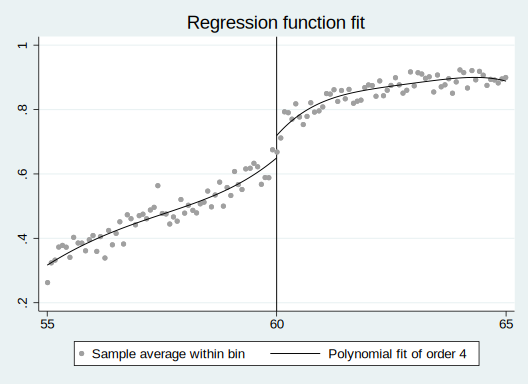

In [40]:
## 图形分析
%stata rdplot retire age, c(60)

可以发现，个体退休的概率随年龄呈明显的上升趋势，在age=60处，retire的值向上出现了一个跳跃。即：受法定退休年龄的影响，中国男性在60岁时退休的可能性大幅上升

Mass points detected in the running variable.

RD Plot with evenly spaced mimicking variance number of bins using polynomial regression.

        Cutoff c = 60 | Left of c  Right of c        Number of obs  =      31641
----------------------+----------------------        Kernel         =    Uniform
        Number of obs |     17009       14632
   Eff. Number of obs |     17009       14632
  Order poly. fit (p) |         4           4
     BW poly. fit (h) |     5.000       5.000
 Number of bins scale |     1.000       1.000

Outcome: health. Running variable: age.
---------------------------------------------
                      | Left of c  Right of c
----------------------+----------------------
        Bins selected |       296         295
   Average bin length |     0.017       0.017
    Median bin length |     0.017       0.017
----------------------+----------------------
    IMSE-optimal bins |         5           4
  Mimicking Var. bins |       296         295
---------------

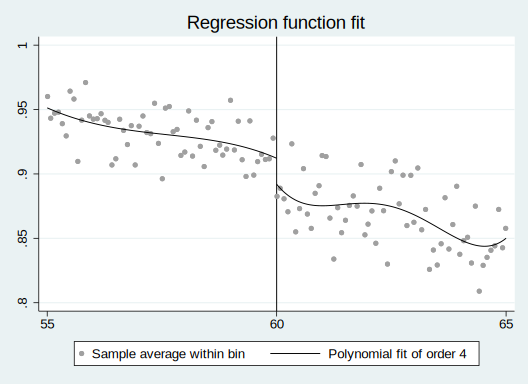

In [42]:
%stata rdplot health age, c(60)

可以发现，个体的健康状况在60岁时出现了一个明显的向下跳跃

In [43]:
# 计算最优带宽
%stata rdbwselect health age, all c(60) fuzzy(retire)

Mass points detected in the running variable.

Bandwidth estimators for fuzzy RD local polynomial regression.

       Cutoff c =  | Left of c  Right of c            Number of obs =      31641
-------------------+----------------------            Kernel        = Triangular
     Number of obs |     17009       14632            VCE method    =         NN
        Min of age |    55.000      60.000
        Max of age |    59.917      65.000
    Order est. (p) |         1           1
    Order bias (q) |         2           2
        Unique obs |        60          61

Outcome: health. Running variable: age. Treatment Status: retire.
--------------------------------------------------------------------------------
                   |         BW est. (h)          |        BW bias (b)
            Method | Left of c         Right of c | Left of c        Right of c
-------------------+------------------------------+-----------------------------
             mserd |     1.589              1.589 |

In [44]:
## 参数估计和统计推断
%stata rdrobust health age, c(60) fuzzy(retire)

Mass points detected in the running variable.

Fuzzy RD estimates using local polynomial regression.

     Cutoff c = 60 | Left of c  Right of c            Number of obs =      31641
-------------------+----------------------            BW type       =      mserd
     Number of obs |     17009       14632            Kernel        = Triangular
Eff. Number of obs |      4696        5116            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     1.589       1.589
       BW bias (b) |     3.092       3.092
         rho (h/b) |     0.514       0.514
        Unique obs |        60          61

First-stage estimates. Outcome: retire. Running variable: age.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Con

In [45]:
## 换用矩形核
%stata rdrobust health age, c(60) fuzzy(retire) kernel(uniform)

Mass points detected in the running variable.

Fuzzy RD estimates using local polynomial regression.

     Cutoff c = 60 | Left of c  Right of c            Number of obs =      31641
-------------------+----------------------            BW type       =      mserd
     Number of obs |     17009       14632            Kernel        =    Uniform
Eff. Number of obs |      3785        4243            VCE method    =         NN
    Order est. (p) |         1           1
    Order bias (q) |         2           2
       BW est. (h) |     1.252       1.252
       BW bias (b) |     2.969       2.969
         rho (h/b) |     0.422       0.422
        Unique obs |        60          61

First-stage estimates. Outcome: retire. Running variable: age.
--------------------------------------------------------------------------------
            Method |   Coef.    Std. Err.    z     P>|z|    [95% Conf. Interval]
-------------------+------------------------------------------------------------
      Con

In [46]:
## 矩形核条件下通过ivregress命令再现rdrobust的结果
stata.run(
    """
    gen z=1 if age>=60 & age<.
    replace z=0 if age<60
    // 配置变量对中处理，保证估计到的retire的回归系数是断点处的因果效应
    replace age=age-60
    """
)


. 
.     gen z=1 if age>=60 & age<.
(17,009 missing values generated)

.     replace z=0 if age<60
(17,009 real changes made)

.     // 配置变量对中
.     replace age=age-60
(31,641 real changes made)

.     
. 


In [47]:
%stata ivregress 2sls health (retire=z) age c.age#z if age>=-1.252 & age<=1.252


Instrumental variables 2SLS regression            Number of obs   =      8,028
                                                  Wald chi2(3)    =      31.59
                                                  Prob > chi2     =     0.0000
                                                  R-squared       =          .
                                                  Root MSE        =     .31553

------------------------------------------------------------------------------
      health | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
      retire |  -.2934861   .1593392    -1.84   0.065    -.6057853    .0188131
         age |   .0119949   .0239413     0.50   0.616    -.0349293    .0589191
             |
     z#c.age |
          1  |   .0082678   .0184432     0.45   0.654    -.0278803    .0444159
             |
       _cons |   1.100541   .1106045     9.95   0.000     .8837602    1.317322
-----

In [50]:
## 多项式回归
stata.run(
    """
    gen age2=age^2
    gen age3=age^3
    gen age4=age^4

    qui reg health c.age##z if age<=3 & age>=-3
    est store m1
    qui reg health (c.age c.age2)##z if age<=3 & age>=-3
    est store m2
    qui reg health (c.age c.age2 c.age3)##z if age<=3 & age>=-3
    est store m3
    qui reg health (c.age c.age2 c.age3 c.age4)##z if age<=3 & age>=-3
    est store m4
    esttab m1 m2 m3 m4, aic bic keep(1.z)
    """
)


. 
.     // gen age2=age^2
.     // gen age3=age^3
.     // gen age4=age^4
. 
.     qui reg health c.age##z if age<=3 & age>=-3

.     est store m1

.     qui reg health (c.age c.age2)##z if age<=3 & age>=-3

.     est store m2

.     qui reg health (c.age c.age2 c.age3)##z if age<=3 & age>=-3

.     est store m3

.     qui reg health (c.age c.age2 c.age3 c.age4)##z if age<=3 & age>=-3

.     est store m4

.     esttab m1 m2 m3 m4, aic bic keep(1.z)

----------------------------------------------------------------------------
                      (1)             (2)             (3)             (4)   
                   health          health          health          health   
----------------------------------------------------------------------------
1.z               -0.0328***      -0.0258*        -0.0284         -0.0401   
                  (-3.77)         (-1.97)         (-1.62)         (-1.80)   
----------------------------------------------------------------------------
N    

In [49]:
%stata ivregress 2sls health (retire=z) age c.age#z if age<=3 & age>=-3


Instrumental variables 2SLS regression            Number of obs   =     18,405
                                                  Wald chi2(3)    =     127.49
                                                  Prob > chi2     =     0.0000
                                                  R-squared       =          .
                                                  Root MSE        =     .30355

------------------------------------------------------------------------------
      health | Coefficient  Std. err.      z    P>|z|     [95% conf. interval]
-------------+----------------------------------------------------------------
      retire |  -.2343489   .0639179    -3.67   0.000    -.3596257   -.1090722
         age |   .0051383   .0065482     0.78   0.433    -.0076959    .0179725
             |
     z#c.age |
          1  |   .0033769   .0051373     0.66   0.511     -.006692    .0134458
             |
       _cons |    1.05926   .0446121    23.74   0.000     .9718218    1.146698
-----

在进行模糊断点回归分析之后，也要对分析结果的稳健性进行检验